<a href="https://colab.research.google.com/github/TAUforPython/fuzzy/blob/main/example%20Fuzzy%20Kalman%20filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# No need to install additional packages in Colab by default for this example

# --- Simulation Setup (Based on the paper's example in Section 4) ---
# System: x_k+1 = [1 h; 0 1] * x_k + w_k
#         y_k   = [1 0] * x_k + v_k
# Where h is uncertain and lies in [h_min, h_max]

# True parameters (for generating observations)
h_true = 0.0105  # Value within the interval, slightly off-center
A_true = np.array([[1, h_true], [0, 1]])
C_true = np.array([[1, 0]])

# Initial state and covariance

In [3]:

x_true_0 = np.array([50.0, 1.0]) # Initial true state
x_hat_0 = np.array([50.0, 0.0])  # Initial estimate guess
P_0 = np.array([[1.0, 0.0], [0.0, 0.5]]) # Initial error covariance

# Noise covariances (from the paper)
Q_true = np.array([[0.0, 0.0], [0.0, 0.1]]) # Process noise covariance
R_true = 0.1  # Measurement noise variance

# Simulation parameters
N = 50  # Number of time steps
dt = 1  # Time step (not explicitly used here, h is the integration factor)

# Interval uncertainty for h (from the paper)
h_nominal = 0.01
h_error = 0.001
h_min = h_nominal - h_error # 0.009
h_max = h_nominal + h_error # 0.011
print(f"Interval for h: [{h_min}, {h_max}]")
print(f"True h used for simulation: {h_true}")

Interval for h: [0.009000000000000001, 0.011]
True h used for simulation: 0.0105


# Membership Functions

In [5]:
# --- Membership Functions (mu_1: Left, mu_2: Center, mu_3: Right) ---
# Using triangular membership functions as described in Fig. 1(d) of the paper
# The paper uses mu_1 for "near left", mu_2 for "near center", mu_3 for "near right"
def get_membership_values(h_val, h_min, h_max):
    """Calculates membership values for Left (mu_1), Center (mu_2), Right (mu_3)"""
    h_range = h_max - h_min
    if h_range == 0:
        return [1.0, 1.0, 1.0] # If interval is a point, all memberships are 1

    h_norm = (h_val - h_min) / h_range # Normalize h to [0, 1]

    # Define the triangle points for each function on the normalized interval [0, 1]
    # mu_1 (Left): peak at 0, zero at 0.5
    mu_1 = max(0, 1 - 2 * h_norm)
    # mu_2 (Center): peak at 0.5, zero at 0 and 1
    mu_2 = max(0, 1 - abs(2 * h_norm - 1))
    # mu_3 (Right): peak at 1, zero at 0.5
    mu_3 = max(0, 2 * h_norm - 1)

    return mu_1, mu_2, mu_3

# --- Kalman Filter Update Step (Prediction and Update) ---
def kalman_step(x_pred, P_pred, y_k, A_k, C_k, Q_k, R_k):
    """Performs one step of the standard Kalman Filter."""
    # --- Prediction ---
    # x_pred = A_k @ x_pred (already calculated outside this function)
    P_pred = A_k @ P_pred @ A_k.T + Q_k

    # --- Update ---
    S = C_k @ P_pred @ C_k.T + R_k
    K = P_pred @ C_k.T / S # Simplified for scalar measurement (results in a (2,1) column vector)
    innovation = y_k - C_k @ x_pred
    x_upd = x_pred + K.flatten() * innovation # K is (2,1), innovation is scalar
    P_upd = (np.eye(len(x_upd)) - np.outer(K.flatten(), C_k)) @ P_pred # Use outer product for gain update
    return x_upd, P_upd, K.flatten(), innovation # Return K as 1D

# --- Generate True States and Observations ---
np.random.seed(42) # For reproducibility
x_true = np.zeros((2, N+1))
y_obs = np.zeros(N+1)
x_true[:, 0] = x_true_0

process_noise = np.random.multivariate_normal([0, 0], Q_true, N)
measurement_noise = np.random.normal(0, np.sqrt(R_true), N+1)

for k in range(N):
    x_true[:, k+1] = A_true @ x_true[:, k] + process_noise[k]
    y_obs[k] = C_true @ x_true[:, k] + measurement_noise[k]
y_obs[N] = C_true @ x_true[:, N] + measurement_noise[N] # Last measurement

# --- Run Standard KF (using the nominal h) ---
A_nom = np.array([[1, h_nominal], [0, 1]]) # Use nominal value for standard KF
x_kf = np.zeros((2, N+1))
P_kf = np.zeros((2, 2, N+1))
x_kf[:, 0] = x_hat_0
P_kf[:, :, 0] = P_0

for k in range(1, N+1):
    x_pred = A_nom @ x_kf[:, k-1] # Prediction step
    P_pred = P_kf[:, :, k-1] # Placeholder, updated in kalman_step
    # Corrected assignment order: x_upd -> x_kf[:, k], P_upd -> P_kf[:, :, k]
    x_upd, P_upd, _, _ = kalman_step(x_pred, P_pred, y_obs[k-1], A_nom, C_true, Q_true, R_true)
    x_kf[:, k] = x_upd
    P_kf[:, :, k] = P_upd



/tmp/ipython-input-3800396880.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_obs[k] = C_true @ x_true[:, k] + measurement_noise[k]
/tmp/ipython-input-3800396880.py:49: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_obs[N] = C_true @ x_true[:, N] + measurement_noise[N] # Last measurement


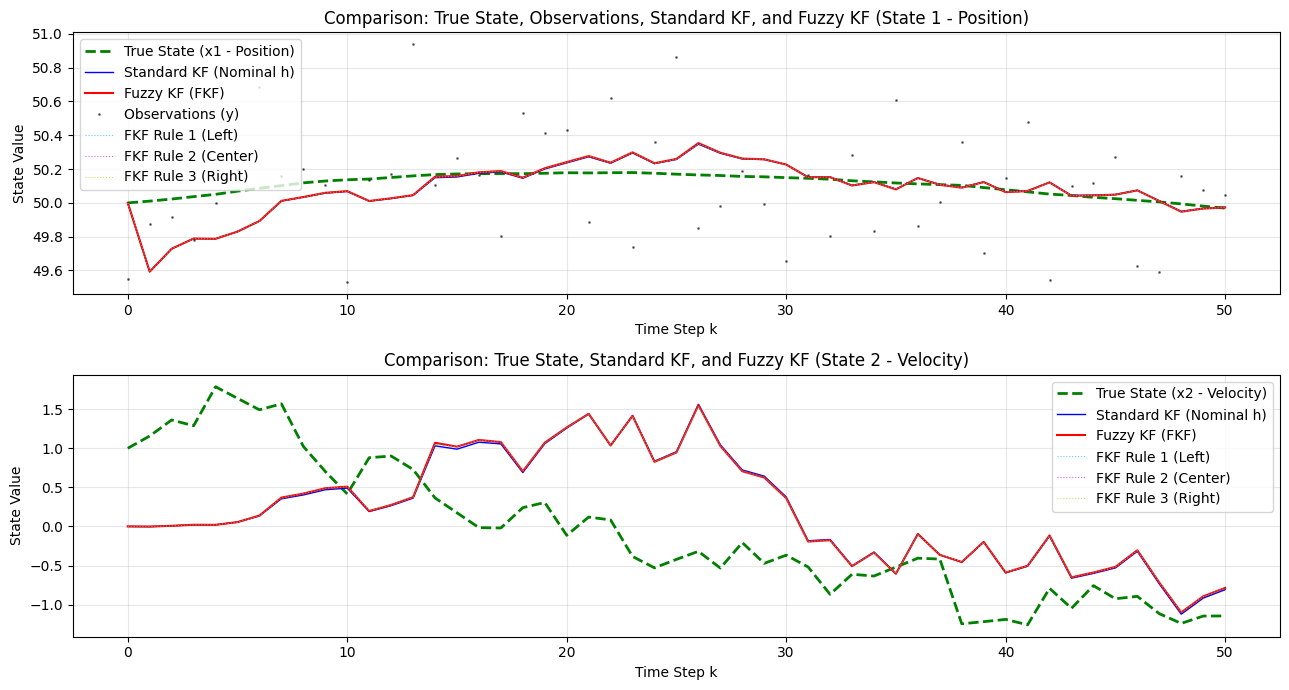

In [7]:
# --- Run Fuzzy Kalman Filter (FKF) ---
x_fkf = np.zeros((2, N+1))
P_fkf = np.zeros((2, 2, N+1))
x_fkf[:, 0] = x_hat_0
P_fkf[:, :, 0] = P_0

# Store estimates from each rule for visualization
x_fkf_rule1 = np.zeros((2, N+1))
x_fkf_rule2 = np.zeros((2, N+1))
x_fkf_rule3 = np.zeros((2, N+1))
x_fkf_rule1[:, 0] = x_hat_0
x_fkf_rule2[:, 0] = x_hat_0
x_fkf_rule3[:, 0] = x_hat_0


for k in range(1, N+1):
    # Get membership values based on the *nominal* value or a representative value.
    # The paper suggests using the current estimate or measurement somehow, but the example
    # implies using the nominal h or a value derived from the interval itself for the membership.
    # A common interpretation is to calculate h_i for each rule based on the membership function
    # shape applied to the interval [h_min, h_max].
    # However, the paper's simulation example (Section 4) calculates h_i based on a
    # *pseudo-noise* value h_k generated within [h_min, h_max].
    # For simplicity and demonstration, let's assume we calculate h_i based on the membership
    # function values at the current *nominal* h.
    # A more faithful implementation might use the membership functions to define how the
    # *range* [h_min, h_max] is sampled for the three rules.
    # Let's follow the spirit of the paper's example more closely:
    # Calculate h_i for each rule using membership values applied to the *interval*.
    # mu_i(h_current) where h_current could be the nominal or derived from the interval shape.
    # The paper's rescaling example shows: h_i = h_min + mu_i(h) * (h_range) / scaling_factor
    # But the core idea from Eq 4 and the rule base is:
    # Rule i uses a specific h_i calculated from membership.
    # Let's define h_i as the value within the interval corresponding to the peak of each membership function:
    # h_1 = h_min (peak of mu_1), h_2 = (h_min+h_max)/2 (peak of mu_2), h_3 = h_max (peak of mu_3)
    # Or, more generally, use the membership function to weight h_min and h_max for each rule's h_i.
    # Let's use the membership function evaluated at the nominal value to determine h_i,
    # but this is ambiguous. The paper's simulation (Eq after Fig 2) shows a rescaling.
    # Let's implement the rescaling logic based on the paper's simulation section more directly:
    # 1. Generate a pseudo-random h_k within [h_min, h_max]
    # 2. Calculate mu_i(h_k)
    # 3. Calculate h_i^(rule) = h_min + mu_i(h_k) * (h_max - h_min)
    # 4. Run KF for each rule using h_i^(rule)
    # 5. Defuzzify using p_i = mu_i(h_k)

    # Simulate the "current" h value for this step (as in the paper's simulation)
    h_current = np.random.uniform(h_min, h_max) # Pseudo-noise, like in paper
    mu_1, mu_2, mu_3 = get_membership_values(h_current, h_min, h_max)

    # Calculate the effective h value for each rule based on membership
    # (This follows the rescaling idea from the paper's simulation)
    h_1_rule = h_min + mu_1 * (h_max - h_min)
    h_2_rule = h_min + mu_2 * (h_max - h_min)
    h_3_rule = h_min + mu_3 * (h_max - h_min)

    # Define system matrices for each rule
    A_1 = np.array([[1, h_1_rule], [0, 1]])
    A_2 = np.array([[1, h_2_rule], [0, 1]])
    A_3 = np.array([[1, h_3_rule], [0, 1]])

    # Run KF prediction-update for each rule
    x_pred_1 = A_1 @ x_fkf[:, k-1]
    x_upd_1, P_upd_1, _, _ = kalman_step(x_pred_1, P_fkf[:, :, k-1].copy(), y_obs[k-1], A_1, C_true, Q_true, R_true)

    x_pred_2 = A_2 @ x_fkf[:, k-1]
    x_upd_2, P_upd_2, _, _ = kalman_step(x_pred_2, P_fkf[:, :, k-1].copy(), y_obs[k-1], A_2, C_true, Q_true, R_true)

    x_pred_3 = A_3 @ x_fkf[:, k-1]
    x_upd_3, P_upd_3, _, _ = kalman_step(x_pred_3, P_fkf[:, :, k-1].copy(), y_obs[k-1], A_3, C_true, Q_true, R_true)

    # Store individual rule estimates for visualization
    x_fkf_rule1[:, k] = x_upd_1
    x_fkf_rule2[:, k] = x_upd_2
    x_fkf_rule3[:, k] = x_upd_3

    # Defuzzification: Weighted average using membership values (mu_i(h_current) = p_i)
    weights = np.array([mu_1, mu_2, mu_3])
    # Ensure weights are not all zero (avoid division by zero)
    if np.sum(weights) > 0:
        x_fkf[:, k] = (mu_1 * x_upd_1 + mu_2 * x_upd_2 + mu_3 * x_upd_3) / np.sum(weights)
        # Simplified P update (paper doesn't specify this clearly for P)
        # A common approach is to weight the covariances similarly or use a more complex formula
        # For this demo, we'll just use the weighted average for the state.
        # P_fkf[:, :, k] = (mu_1 * P_upd_1 + mu_2 * P_upd_2 + mu_3 * P_upd_3) / np.sum(weights)
        # Let's just take the covariance from the most "likely" rule (highest membership) for simplicity in visualization
        dominant_rule_idx = np.argmax(weights)
        P_fkf[:, :, k] = [P_upd_1, P_upd_2, P_upd_3][dominant_rule_idx]
    else:
        # Fallback if all weights are zero (shouldn't happen with triangular norms)
        x_fkf[:, k] = x_upd_1 # Default to rule 1
        P_fkf[:, :, k] = P_upd_1

# --- Visualization ---
plt.figure(figsize=(13, 7))

# Plot State 1 (Position)
plt.subplot(2, 1, 1)
plt.plot(range(N+1), x_true[0, :], 'g--', label='True State (x1 - Position)', linewidth=2)
plt.plot(range(N+1), x_kf[0, :], 'b-', label='Standard KF (Nominal h)', linewidth=1)
plt.plot(range(N+1), x_fkf[0, :], 'r-', label='Fuzzy KF (FKF)', linewidth=1.5)
plt.plot(range(N+1), y_obs, 'k.', label='Observations (y)', alpha=0.5, markersize=2)
plt.plot(range(N+1), x_fkf_rule1[0, :], 'c:', label='FKF Rule 1 (Left)', alpha=0.6, linewidth=0.8)
plt.plot(range(N+1), x_fkf_rule2[0, :], 'm:', label='FKF Rule 2 (Center)', alpha=0.6, linewidth=0.8)
plt.plot(range(N+1), x_fkf_rule3[0, :], 'y:', label='FKF Rule 3 (Right)', alpha=0.6, linewidth=0.8)

plt.title('Comparison: True State, Observations, Standard KF, and Fuzzy KF (State 1 - Position)')
plt.xlabel('Time Step k')
plt.ylabel('State Value')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot State 2 (Velocity)
plt.subplot(2, 1, 2)
plt.plot(range(N+1), x_true[1, :], 'g--', label='True State (x2 - Velocity)', linewidth=2)
plt.plot(range(N+1), x_kf[1, :], 'b-', label='Standard KF (Nominal h)', linewidth=1)
plt.plot(range(N+1), x_fkf[1, :], 'r-', label='Fuzzy KF (FKF)', linewidth=1.5)
# plt.plot(range(N+1), y_obs, 'k.', label='Observations (y)', alpha=0.5) # Observations don't directly show velocity
plt.plot(range(N+1), x_fkf_rule1[1, :], 'c:', label='FKF Rule 1 (Left)', alpha=0.6, linewidth=0.8)
plt.plot(range(N+1), x_fkf_rule2[1, :], 'm:', label='FKF Rule 2 (Center)', alpha=0.6, linewidth=0.8)
plt.plot(range(N+1), x_fkf_rule3[1, :], 'y:', label='FKF Rule 3 (Right)', alpha=0.6, linewidth=0.8)

plt.title('Comparison: True State, Standard KF, and Fuzzy KF (State 2 - Velocity)')
plt.xlabel('Time Step k')
plt.ylabel('State Value')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



# Demonstration of Robustness


--- Robustness Demonstration ---
Running FKF designed for h in [0.009000000000000001, 0.011] with true h = 0.0115 (outside interval)


/tmp/ipython-input-465418472.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_obs_r[k] = C_true @ x_true_r[:, k] + measurement_noise_r[k]
/tmp/ipython-input-465418472.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_obs_r[N] = C_true @ x_true_r[:, N] + measurement_noise_r[N]


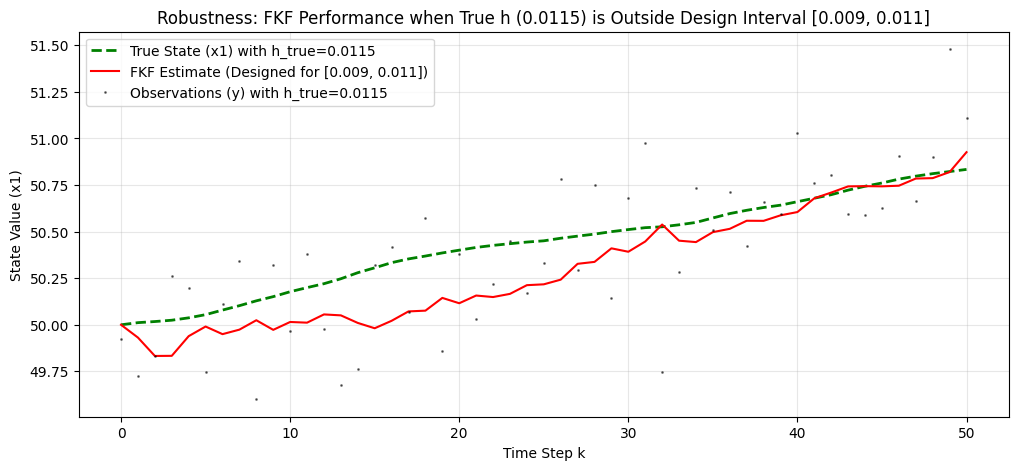

The FKF estimate (red) generally tracks the true state (green) reasonably well even though the true h (0.0115) is outside the interval [0.009, 0.011] used for its design, demonstrating its robustness to parameter variations beyond the modeling uncertainty.


In [9]:
# FKF is robust when the true parameter goes outside the design interval.
# Let's simulate this by running the FKF designed for [0.009, 0.011] with a true h of 0.0115 (outside interval)
h_true_robust = 0.0115
A_true_robust = np.array([[1, h_true_robust], [0, 1]])
print(f"\n--- Robustness Demonstration ---")
print(f"Running FKF designed for h in [{h_min}, {h_max}] with true h = {h_true_robust} (outside interval)")

# Re-generate observations with the new true h
x_true_r = np.zeros((2, N+1))
y_obs_r = np.zeros(N+1)
x_true_r[:, 0] = x_true_0
process_noise_r = np.random.multivariate_normal([0, 0], Q_true, N)
measurement_noise_r = np.random.normal(0, np.sqrt(R_true), N+1)

for k in range(N):
    x_true_r[:, k+1] = A_true_robust @ x_true_r[:, k] + process_noise_r[k]
    y_obs_r[k] = C_true @ x_true_r[:, k] + measurement_noise_r[k]
y_obs_r[N] = C_true @ x_true_r[:, N] + measurement_noise_r[N]

# Run FKF again with the same setup (interval [0.009, 0.011]) but new observations
x_fkf_r = np.zeros((2, N+1))
P_fkf_r = np.zeros((2, 2, N+1))
x_fkf_r[:, 0] = x_hat_0
P_fkf_r[:, :, 0] = P_0

for k in range(1, N+1):
    h_current = np.random.uniform(h_min, h_max) # FKF still uses its design interval
    mu_1, mu_2, mu_3 = get_membership_values(h_current, h_min, h_max)
    h_1_rule = h_min + mu_1 * (h_max - h_min)
    h_2_rule = h_min + mu_2 * (h_max - h_min)
    h_3_rule = h_min + mu_3 * (h_max - h_min)

    A_1 = np.array([[1, h_1_rule], [0, 1]])
    A_2 = np.array([[1, h_2_rule], [0, 1]])
    A_3 = np.array([[1, h_3_rule], [0, 1]])

    x_pred_1 = A_1 @ x_fkf_r[:, k-1]
    x_upd_1, P_upd_1, _, _ = kalman_step(x_pred_1, P_fkf_r[:, :, k-1].copy(), y_obs_r[k-1], A_1, C_true, Q_true, R_true)

    x_pred_2 = A_2 @ x_fkf_r[:, k-1]
    x_upd_2, P_upd_2, _, _ = kalman_step(x_pred_2, P_fkf_r[:, :, k-1].copy(), y_obs_r[k-1], A_2, C_true, Q_true, R_true)

    x_pred_3 = A_3 @ x_fkf_r[:, k-1]
    x_upd_3, P_upd_3, _, _ = kalman_step(x_pred_3, P_fkf_r[:, :, k-1].copy(), y_obs_r[k-1], A_3, C_true, Q_true, R_true)

    weights = np.array([mu_1, mu_2, mu_3])
    if np.sum(weights) > 0:
        x_fkf_r[:, k] = (mu_1 * x_upd_1 + mu_2 * x_upd_2 + mu_3 * x_upd_3) / np.sum(weights)
        dominant_rule_idx = np.argmax(weights)
        P_fkf_r[:, :, k] = [P_upd_1, P_upd_2, P_upd_3][dominant_rule_idx]
    else:
        x_fkf_r[:, k] = x_upd_1
        P_fkf_r[:, :, k] = P_upd_1

# Plot robustness demonstration for State 1
plt.figure(figsize=(12, 5))
plt.plot(range(N+1), x_true_r[0, :], 'g--', label='True State (x1) with h_true=0.0115', linewidth=2)
plt.plot(range(N+1), x_fkf_r[0, :], 'r-', label='FKF Estimate (Designed for [0.009, 0.011])', linewidth=1.5)
plt.plot(range(N+1), y_obs_r, 'k.', label='Observations (y) with h_true=0.0115', alpha=0.5, markersize=2)
plt.title('Robustness: FKF Performance when True h (0.0115) is Outside Design Interval [0.009, 0.011]')
plt.xlabel('Time Step k')
plt.ylabel('State Value (x1)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("The FKF estimate (red) generally tracks the true state (green) reasonably well even though the true h (0.0115) is outside the interval [0.009, 0.011] used for its design, demonstrating its robustness to parameter variations beyond the modeling uncertainty.")
